# Clasificador de Mariposas - Pablo García Muñoz

In [18]:
# Imports
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
# Lecutra de datos
dataset_path = "dataset/"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
valid_path = os.path.join(dataset_path, "valid")
print(f"Entrenamiento: {train_path}, Clases: {len(os.listdir(train_path))}, Total: {sum([len(files) for r, d, files in os.walk(train_path)])}\nValidación: {valid_path}, Clases: {len(os.listdir(valid_path))}, Total: {sum([len(files) for r, d, files in os.walk(valid_path)])}\nPrueba: {test_path}, Clases: {len(os.listdir(test_path))}, Total: {sum([len(files) for r, d, files in os.walk(test_path)])}")
img_count = sum([len(files) for r, d, files in os.walk(dataset_path)])
print(f"Total de imágenes: {img_count}")
total_classes = len(os.listdir(train_path))
print(f"Clases: {total_classes}")

Entrenamiento: dataset/train, Clases: 100, Total: 12594
Validación: dataset/valid, Clases: 100, Total: 500
Prueba: dataset/test, Clases: 100, Total: 500
Total de imágenes: 13597
Clases: 100


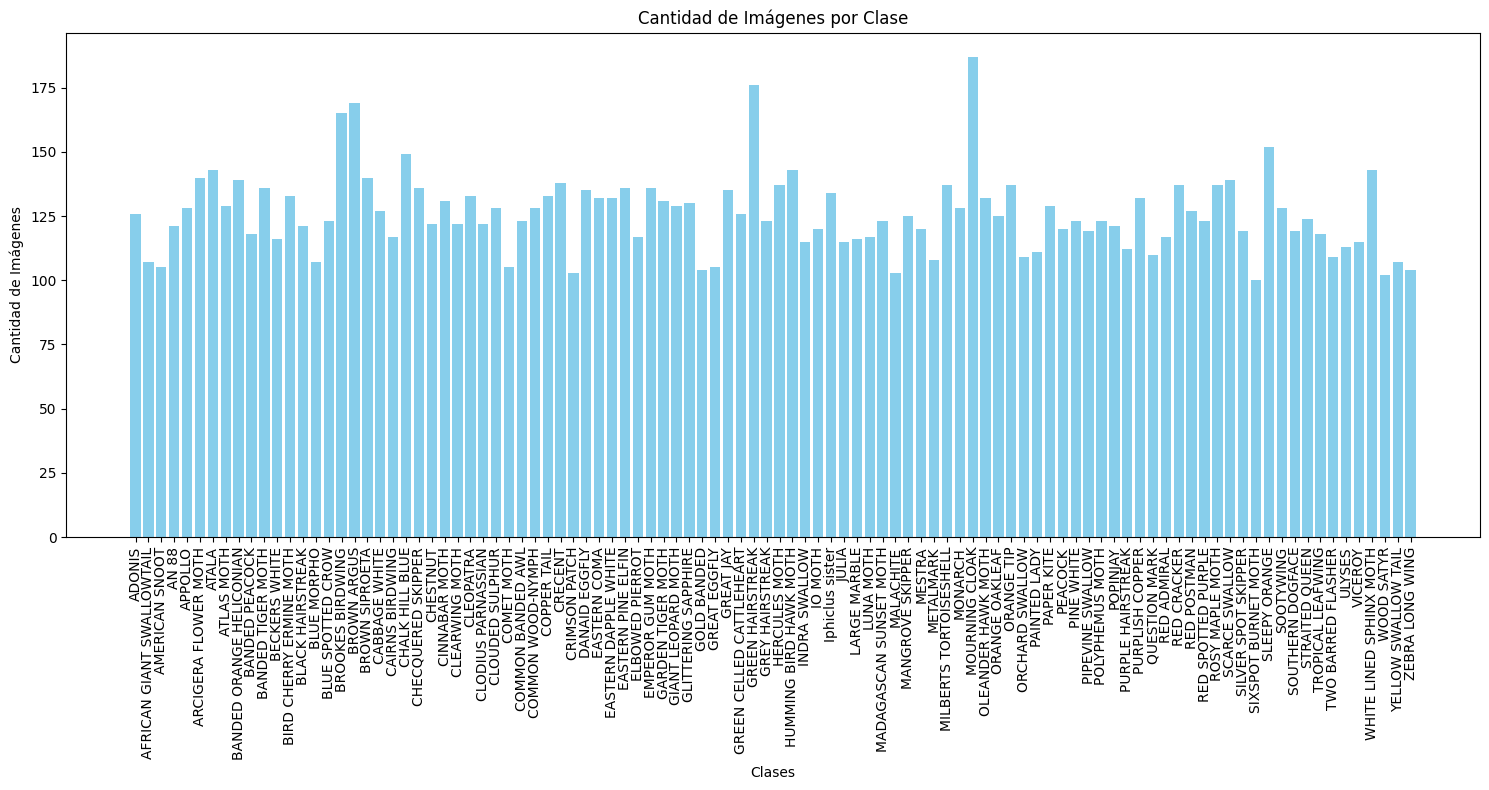

In [20]:
# Contar las imágenes en cada clase
data = {}
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        data[class_name] = len([file for file in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, file))])

# Extraer las clases y las cantidades
clases = list(data.keys())
cantidades = list(data.values())

# Crear la gráfica
plt.figure(figsize=(15, 8))
plt.bar(clases, cantidades, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Cantidad de Imágenes por Clase')
plt.xticks(rotation=90)  # Rotar etiquetas, alinearlas a la derecha y añadir padding
plt.tight_layout()
plt.show()

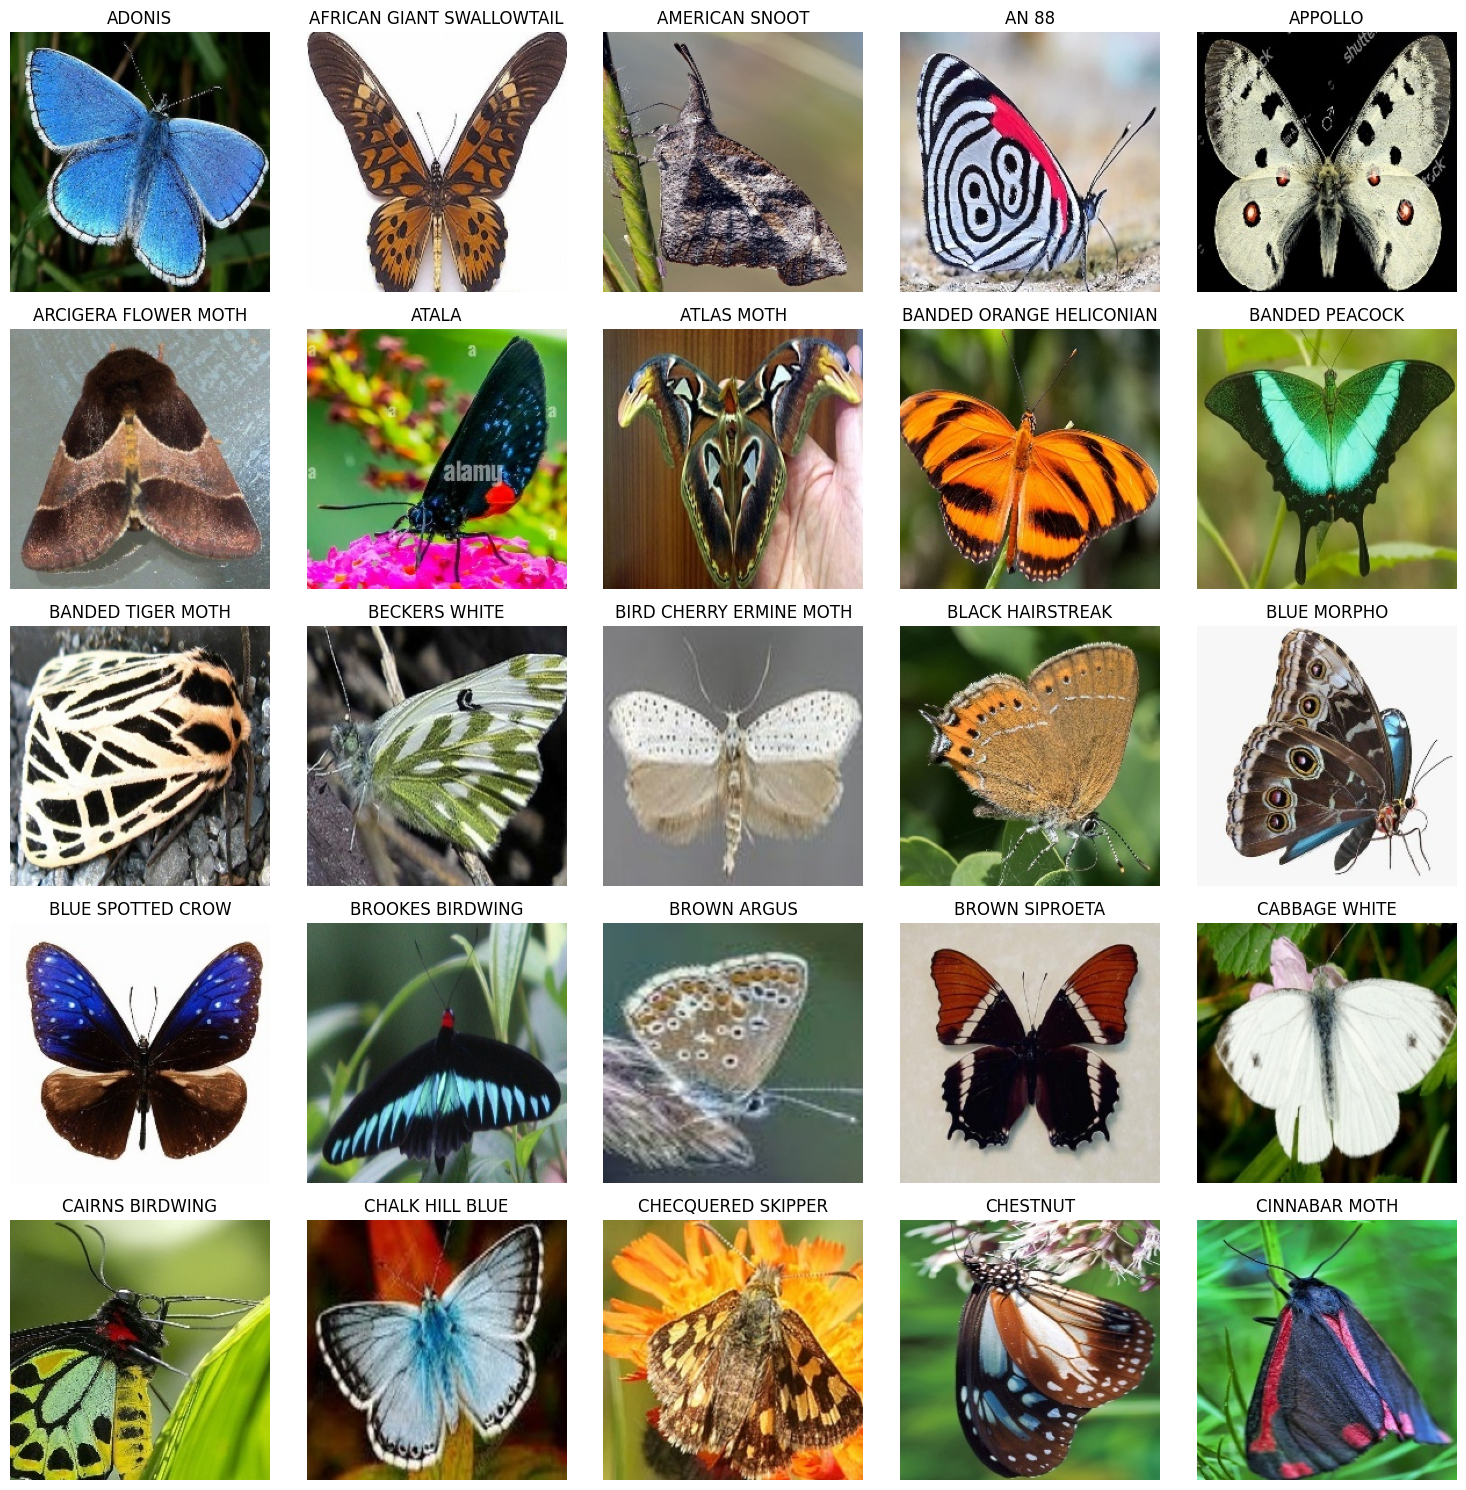

In [21]:
# Clases del entrenamiento
classes = os.listdir(train_path)

plt.figure(figsize=(15, 15))
for i, class_name in enumerate(classes):
    # Carpeta de cada clase
    class_folder = os.path.join(train_path, class_name)

    # Primera imagen de cada clase
    image_name = os.listdir(class_folder)[0]
    # Ruta de la imagen
    image_path = os.path.join(class_folder, image_name)

    # Cargar imagen
    img = image.load_img(image_path, target_size=(224, 224))
    # Mostrar imagen
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

    # Primeras 24 imágenes
    if i >= 24:
        break

plt.tight_layout()
plt.show()


In [22]:
# Función para verificar imágenes inválidas y carpetas vacías
def verify_dataset(dataset_path):
    invalid_images = []
    empty_classes = []

    # Iterar sobre las carpetas de clases
    for class_name in sorted(os.listdir(dataset_path)):
        class_folder = os.path.join(dataset_path, class_name)

        if not os.listdir(class_folder):  # Verificar si la carpeta está vacía
            empty_classes.append(class_folder)
        else:
            for img_file in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_file)
                try:
                    img = Image.open(img_path)  # Abrir la imagen
                    img.verify()  # Verificar si la imagen es válida
                except (IOError, SyntaxError):  # Capturar errores en archivos corruptos
                    invalid_images.append(img_path)

    # Resultados
    if empty_classes:
        print("Clases vacías encontradas:")
        for empty in empty_classes:
            print(empty)
    else:
        print("No se encontraron clases vacías.")

    if invalid_images:
        print("\nImágenes inválidas encontradas:")
        for invalid in invalid_images:
            print(invalid)
    else:
        print("No se encontraron imágenes inválidas.")

In [23]:
# Llamar a la función para verificar los conjuntos de datos
print("Verificación de train:")
verify_dataset(train_path)
print("Verificación de test:")
verify_dataset(test_path)
print("Verificación de valid:")
verify_dataset(valid_path)

Verificación de train:
No se encontraron clases vacías.
No se encontraron imágenes inválidas.
Verificación de test:
No se encontraron clases vacías.
No se encontraron imágenes inválidas.
Verificación de valid:
No se encontraron clases vacías.
No se encontraron imágenes inválidas.


In [24]:
# Configuración de parámetros
img_height, img_width = 224, 224  # Tamaño de las imágenes
batch_size = 32 # Tamaño del lote

In [25]:
# Cargar las imágenes desde las carpetas
train_data = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),  # Redimensiona las imágenes
    batch_size=32,
    label_mode='categorical'  # Codifica las etiquetas en formato one-hot
)

val_data = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [26]:
# Definir la capa de aumentación de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Volteo horizontal y vertical
    layers.RandomRotation(0.2),                    # Rotaciones aleatorias
    layers.RandomZoom(0.2),                        # Zoom aleatorio
    layers.RandomContrast(0.2)                     # Contraste aleatorio
])

In [27]:
# Esto no aumenta la cantidad de imágenes, solo las modifica y se aplican en tiempo de ejecución
# Integración en el pipeline de datos
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)  # Aplicar aumentación solo al conjunto de entrenamiento

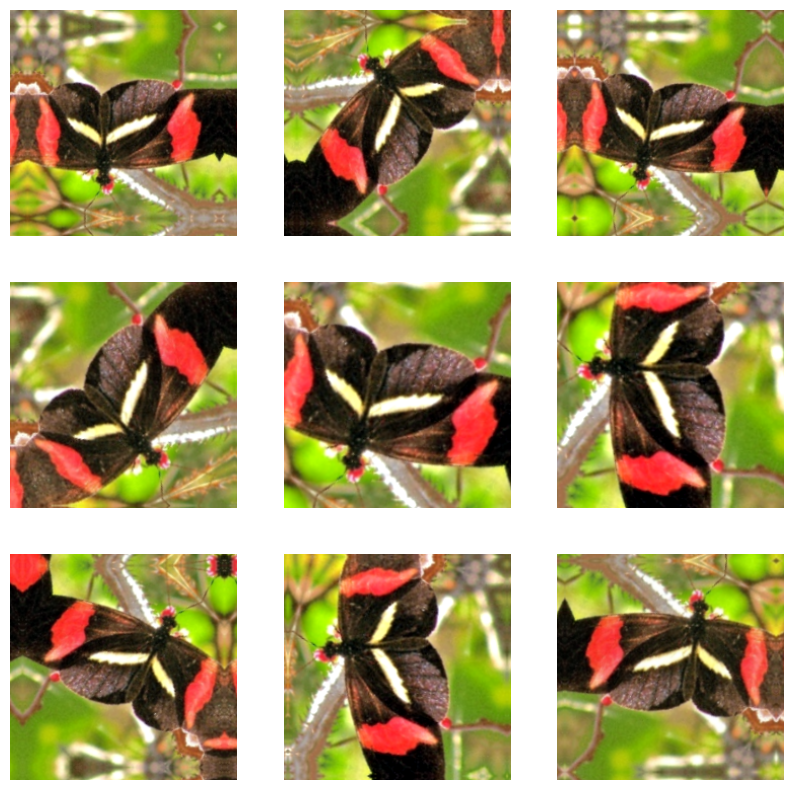

In [28]:
# Visualizar algunas imágenes aumentadas
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):  # Tomar un batch de imágenes
    for i in range(9):
        augmented_image = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [29]:
# Normalizar las imágenes (0 a 1)
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

In [30]:
# Opcional: Cachear y prefetch para mejorar el rendimiento
train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
# Modelo CNN
model_dom = models.Sequential([
    # Capas convolucionales
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # GlobalAveragePooling en lugar de Flatten
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(total_classes, activation='softmax')
])

c:\Users\pablo.garcia.munoz\Desktop\TFM\Butterfly\butter-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# Compilar el modelo
model_dom.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
# Resumen del modelo
model_dom.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,132 (1.66 MB)

 Trainable params: 435,172 (1.66 MB)

 Non-trainable params: 960 (3.75 KB)

In [34]:
# Crear el callback de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # Métrica a monitorear
    patience=10,              # Número de épocas sin mejora antes de detenerse
    restore_best_weights=True  # Restaurar los mejores pesos
)

In [35]:
# Configuración del callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # Métrica que se supervisará
    factor=0.5,               # Reducir el learning rate a la mitad
    patience=3,               # Número de épocas sin mejora antes de reducir
    min_lr=1e-6               # Learning rate mínimo
)

In [36]:
# Entrenar el modelo
epochs = 50
history = model_dom.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model_dom.evaluate(val_data)
print(f"Precisión en validación: {val_accuracy * 100:.2f}%")


def plot_training_history(history):
    # Pérdida
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.title('Curvas de Pérdida')

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.title('Curvas de Precisión')

    plt.show()

# Llamar a la función para graficar
plot_training_history(history)

# Guardar el modelo entrenado
model_dom.save("butterfly_cnn_model.h5")
print("Modelo guardado como butterfly_cnn_model.keras")

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.0823 - loss: 4.1097 - val_accuracy: 0.0300 - val_loss: 5.6111 - learning_rate: 0.0010
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.2266 - loss: 3.0284 - val_accuracy: 0.2240 - val_loss: 3.1954 - learning_rate: 0.0010
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - accuracy: 0.3352 - loss: 2.5188 - val_accuracy: 0.4500 - val_loss: 2.0350 - learning_rate: 0.0010
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.4310 - loss: 2.1171 - val_accuracy: 0.5700 - val_loss: 1.6348 - learning_rate: 0.0010
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.5071 - loss: 1.7932 - val_accuracy: 0.6780 - val_loss: 1.2295 - learning_rate: 0.0010
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.5822 - loss: 1.5289 - val_accuracy: 0.6340 - val_loss: 1.2856 - learning_rate: 0.0010
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.6375 - loss: 1.

KeyboardInterrupt: 

In [ ]:
model_prueba = load_model("butterfly_cnn_model_Domingo.keras")

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

Found 500 files belonging to 100 classes.


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.6565 - loss: 208.7194
Pérdida en prueba: 243.0807
Precisión en prueba: 59.20%
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step

Informe de clasificación:
                           precision    recall  f1-score   support

                   ADONIS       0.00      0.00      0.00         5
AFRICAN GIANT SWALLOWTAIL       0.00      0.00      0.00         5
           AMERICAN SNOOT       0.00      0.00      0.00         5
                    AN 88       0.00      0.00      0.00         5
                  APPOLLO       0.00      0.00      0.00         5
     ARCIGERA FLOWER MOTH       0.00      0.00      0.00         5
                    ATALA       0.00      0.00      0.00         5
               ATLAS MOTH       0.00      0.00      0.00         5
 BANDED ORANGE HELICONIAN       0.00      0.00      0.00         5
           BANDED PEACOCK       0.00      0.00      0.00         5
        BANDED TIGER MOTH       0.00      0.00      0.00     

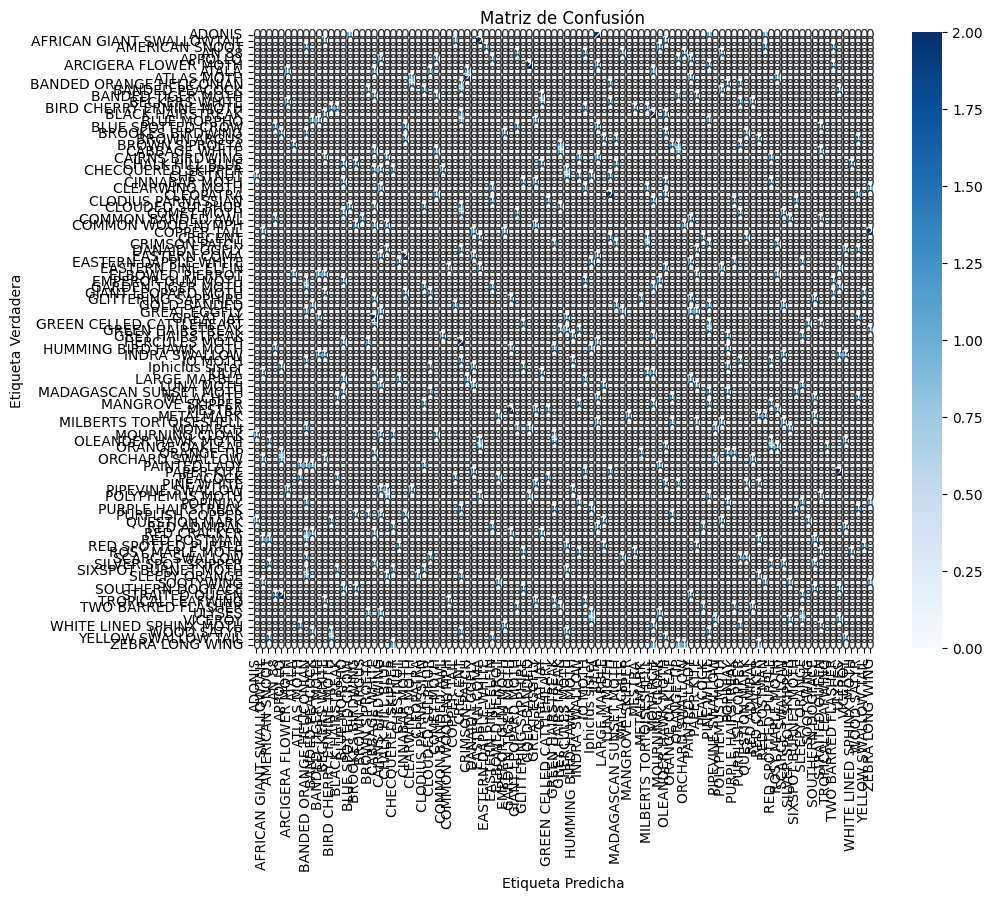

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model_prueba.evaluate(test_data)
print(f"Pérdida en prueba: {test_loss:.4f}")
print(f"Precisión en prueba: {test_accuracy * 100:.2f}%")

# Generar predicciones
y_pred = np.argmax(model_prueba.predict(test_data), axis=1)  # Etiquetas predichas
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_data])  # Etiquetas verdaderas

# Etiquetas de las clases
class_names = test_data.class_names

# Informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

"""
# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.ylabel("Etiqueta Verdadera")
plt.xlabel("Etiqueta Predicha")
plt.title("Matriz de Confusión")
plt.show()
"""